In [39]:
#Importation des modules
from tqdm import tqdm
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models, optimizers, Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [40]:
#Fonction de chargement des images labellisées
def load_data():
    data_path = "./images/train"
    classes = {'clean':0, 'dirty':1}
    imgs = []
    labels = []

    for (cl, i) in classes.items():
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if (elt.find('.jpg') > 0 or elt.find('.jpeg') > 0)]
        for img in tqdm(images_path):
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                image = Image.open(path)
                image = image.resize((256, 256))
                imgs.append(np.array(image))
                labels.append(i)

    X = np.array(imgs)
    y = np.array(labels)

    # Finally we shuffle:
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    first_split = int(len(imgs) /6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [41]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data()

100%|██████████| 82/82 [00:00<00:00, 129.53it/s]


In [42]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(114, 256, 256, 3) (35, 256, 256, 3) (29, 256, 256, 3)
(114,) (35,) (29,)


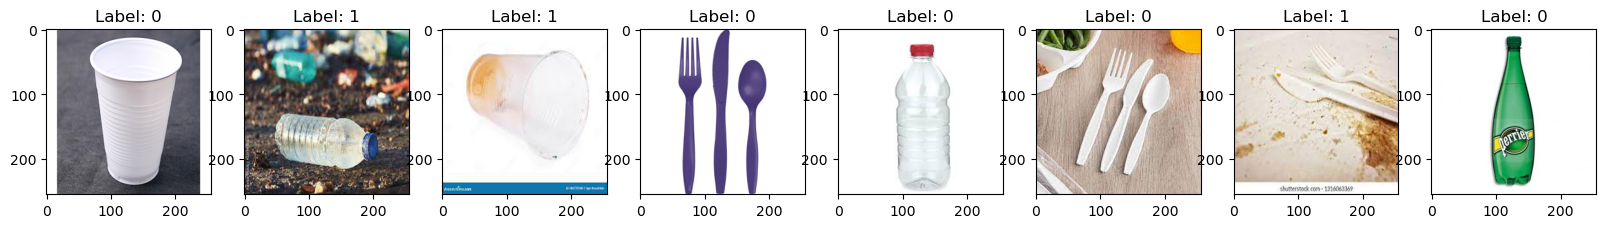

In [43]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")

In [44]:
#Récupération du modèle pré-entrainé Xception, sans la dernière couche "fully connected"
def load_model():
    model = Xception(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model

In [45]:
xception = load_model()
#xception.summary()

In [46]:
#Désactivtion de l'entrainement des paramètres du modèle
def set_nontrainable_layers(model):
    model.trainable = False
    return model

set_nontrainable_layers(xception)
#xception.summary()

<Functional name=xception, built=True>

In [49]:
# Fonction globale qui charge le modèle pré-entrainé, y ajoute les couches de sortie, et le compile
def build_model():
    xception = load_model()
    xception = set_nontrainable_layers(xception)
    inputs = Input(shape=(256, 256, 3))
    x = xception(inputs, training=False)
    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)

    opt = optimizers.RMSprop(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [50]:
model = build_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │   134,218,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,081,257 (591.59 MB)

 Trainable params: 134,219,777 (512.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [51]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=50, 
                    batch_size=16, 
                    callbacks=[es])

Epoch 1/50


8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4767 - loss: 407.5888 - val_accuracy: 0.4857 - val_loss: 259.2370
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5729 - loss: 317.1560 - val_accuracy: 0.4857 - val_loss: 239.9569
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7213 - loss: 165.7668 - val_accuracy: 0.6286 - val_loss: 193.7608
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6973 - loss: 111.4885 - val_accuracy: 0.6571 - val_loss: 70.8619
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8317 - loss: 44.7874 - val_accuracy: 0.6571 - val_loss: 78.9567
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7685 - loss: 68.0118 - val_accuracy: 0.5143 - val_loss: 147.4044
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7094 - loss: 78.9632 - val_accuracy: 0.8000 - val_loss: 45.6169
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9451 - loss: 7.9209 - val_accuracy: 0.7714 - val_loss: 37.7

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

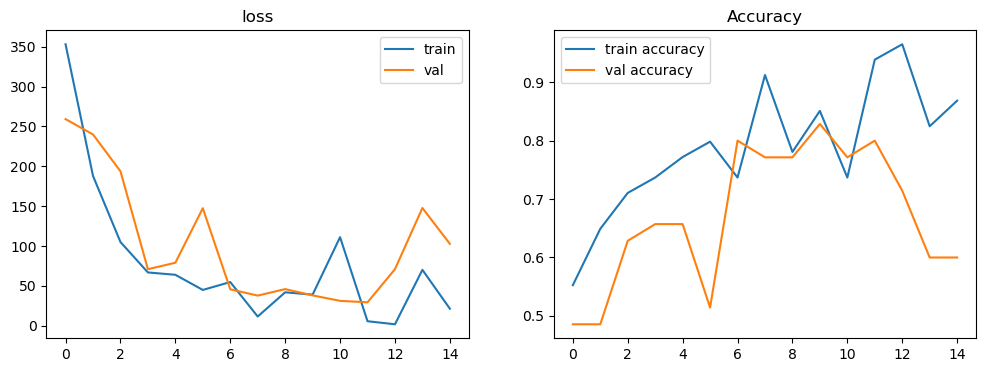

In [52]:
#Tracé des courbes du train et de la validation
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

plot_history(history)

In [55]:
res_vgg = model.evaluate(X_test, y_test)
test_accuracy_vgg = res_vgg[-1]

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7241 - loss: 48.3849
test_accuracy_vgg = 72.0 %


In [57]:
#Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True,
    brightness_range = (0.5, 1.),
    zoom_range = (0.3, 1.5))

datagen.fit(X_train)

model_data_aug = build_model()

train_flow = datagen.flow(X_train, y_train, batch_size=16)
val_flow = datagen.flow(X_val, y_val, batch_size=16)

es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history_data_aug = model_data_aug.fit(train_flow,
                                      validation_data = val_flow, 
                                      epochs = 50,
                                      callbacks = [es])


Epoch 1/50


c:\Users\Simplon\AppData\Local\anaconda3\envs\projet-p4\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.4901 - loss: 261.4608 - val_accuracy: 0.5143 - val_loss: 161.7044
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6081 - loss: 81.8960 - val_accuracy: 0.7429 - val_loss: 19.9880
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6629 - loss: 67.7832 - val_accuracy: 0.6000 - val_loss: 129.3693
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.6112 - loss: 49.0197 - val_accuracy: 0.5143 - val_loss: 128.9023
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.6009 - loss: 133.6030 - val_accuracy: 0.6857 - val_loss: 21.5272
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.7264 - loss: 39.1956 - val_accuracy: 0.4857 - val_loss: 90.2330
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5163 - loss: 79.4823 - val_accuracy: 0.8571 - val_loss: 10.3952
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.5861 - loss: 61.5259 - val_accuracy: 0.5429 - val_loss: 141.41

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

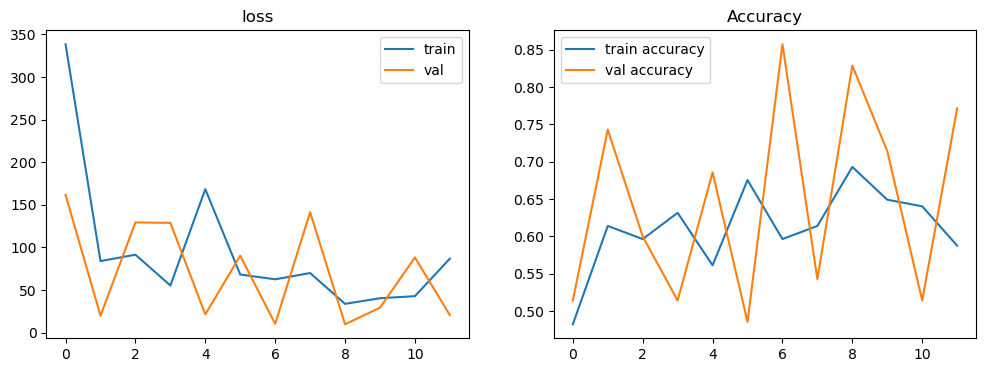

In [58]:
plot_history(history_data_aug)

In [59]:
res_aug = model_data_aug.evaluate(X_test, y_test)
print(res_aug)
test_accuracy_aug = res_aug[-1]

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")
print(f"test_accuracy_aug = {round(test_accuracy_aug,2)*100} %")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6207 - loss: 40.3837
[40.383697509765625, 0.6206896305084229]
test_accuracy_vgg = 72.0 %
test_accuracy_aug = 62.0 %


In [60]:
# Affinage en réentrainant TOUT le modèle avec un learning rate très faible
model.trainable = True

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc'])
print("Ré-entrainement de tout le modèle")
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          steps_per_epoch=1,
          epochs=5,
          validation_steps=1)


Ré-entrainement de tout le modèle
Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - acc: 0.9737 - loss: 1.2830 - val_acc: 0.7714 - val_loss: 53.3941
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00


c:\Users\Simplon\AppData\Local\anaconda3\envs\projet-p4\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - acc: 0.9123 - loss: 11.7434 - val_acc: 0.8286 - val_loss: 34.4757
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - acc: 0.0000e+00 - loss: 0.0000e+00 - val_acc: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - acc: 0.9737 - loss: 1.1665 - val_acc: 0.8286 - val_loss: 34.6763


In [37]:
#Sauvegarde du modèle pour l'embarquer dans l'application
model.save('saved_model')

# Export Tensorflow lite
# intéressant pour obtenir un modèle plus léger et donc plus facilement "embarquable"
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()
with open('../static/model/model_dirtyclean.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [61]:
#Sauvergarde du modèle au "format" keras
model.save("../static/model/model_ludo.keras")